# Wavelets

Generating single numpy with cwts.  

- cwt of 50 seconds eeg of each pair variable in banana montage
- Average of cwts in each group (5 channels)
- mean pooling, reducing by 5
- Keeping 1Hz to 50 Hz (I think)
- storing 10 seconds

Run kaggle versions to generate the datasets.




**Table of contents**<a id='toc0_'></a>    
- [Definitions](#toc1_)    
- [Playing with cwt](#toc2_)    
- [Single file for cwt](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/  

https://github.com/taspinar/siml

The general rule is that this approach of using the Fourier Transform will work very well when the frequency spectrum is stationary. That is, the frequencies present in the signal are not time-dependent; if a signal contains a frequency of x Hz this frequency should be present equally anywhere in the signal.

The main problem with this approach is that you run into the theoretical limits of the Fourier Transform known as the uncertainty principle. The smaller we make the size of the window the more we will know about where a frequency has occurred in the signal, but less about the frequency value itself. The larger we make the size of the window the more we will know about the frequency value and less about the time.

EDG: what if I use sfft for the 50 seconds sample to grab all frequencies, and then do sfft for small chunks and compare the resulting frequencies with the ones in the complete sample? (this is what wavelets do)

The Wavelet Transform has:
- for small frequency values a high resolution in the frequency domain, low resolution in the time- domain,
- for large frequency values a low resolution in the frequency domain, high resolution in the time domain.

The best way to choose the right wavelet is to do a lot of trial-and-error and a little bit of literature research.






Daubechies order 4
wavelet was found to be the most appropriate for
analysis of epileptic EEG data. (2003, Adeli, pag 17)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
from scipy.signal import sosfiltfilt, butter

# import timeit

base_dir = "../../kaggle_data/hms"
# base_dir = "../../data/hms"
# base_dir = "/kaggle/input/hms-harmful-brain-activity-classification"

data_dir = '../data'
# data_dir = '/kaggle/input/hms-indices-train-val-test-v1'

output_dir = '../data/'
# output_dir = ''

fs = 200  # Sample rate.

df_traincsv = pd.read_csv(f'{base_dir}/train.csv')

TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']

df_traincsv = pd.read_csv(f'{base_dir}/train.csv')
df_traincsv.loc[df_traincsv.expert_consensus == 'Seizure', 'target'] = 0
df_traincsv.loc[df_traincsv.expert_consensus == 'LPD', 'target'] = 1
df_traincsv.loc[df_traincsv.expert_consensus == 'GPD', 'target'] = 2
df_traincsv.loc[df_traincsv.expert_consensus == 'LRDA', 'target'] = 3
df_traincsv.loc[df_traincsv.expert_consensus == 'GRDA', 'target'] = 4
df_traincsv.loc[df_traincsv.expert_consensus == 'Other', 'target'] = 5

# Transform votes into percentages.
df_traincsv['sum_votes'] = df_traincsv.seizure_vote + df_traincsv.lpd_vote + df_traincsv.gpd_vote	+ df_traincsv.lrda_vote + df_traincsv.grda_vote + df_traincsv.other_vote
df_traincsv['seizure_vote'] = df_traincsv.seizure_vote/df_traincsv.sum_votes
df_traincsv['lpd_vote'] = df_traincsv.lpd_vote/df_traincsv.sum_votes
df_traincsv['gpd_vote'] = df_traincsv.gpd_vote/df_traincsv.sum_votes
df_traincsv['lrda_vote'] = df_traincsv.lrda_vote/df_traincsv.sum_votes
df_traincsv['grda_vote'] = df_traincsv.grda_vote/df_traincsv.sum_votes
df_traincsv['other_vote'] = df_traincsv.other_vote/df_traincsv.sum_votes

idxs_train = np.load(f'{data_dir}/03_stratified_v2_idxs_train.npy')
idxs_val = np.load(f'{data_dir}/03_stratified_v2_idxs_val.npy')
idxs_test = np.load(f'{data_dir}/03_stratified_v2_idxs_test.npy')
df_train = df_traincsv.loc[idxs_train]
df_val = df_traincsv.loc[idxs_val]
df_test = df_traincsv.loc[idxs_test]

print("Added target column. Transformed into percentages.")
print("Train:", len(df_train))
print("Val:", len(df_val))
print("Test:", len(df_test))


Added target column. Transformed into percentages.
Train: 12186
Val: 2148
Test: 1248


## <a id='toc1_'></a>[Definitions](#toc0_)

In [2]:
# 2024022800
def banana(eeg_absolute, filter=False, fs=200.0):
    '''Returns pandas dataframe with a banana montage.

    filter: False or [low freq, high freq]
    '''
    if filter:
        filtered_data = eeg_absolute.copy()
        # Apply band pass.
        sos = butter(5, filter, btype='bandpass', fs=fs, output='sos')
        for c in filtered_data.columns:
            filtered_data[c] = sosfiltfilt(sos, filtered_data[c])
    else:
        filtered_data = eeg_absolute.copy()

    eeg = pd.DataFrame(data={
        'Fp1-F7' : filtered_data.Fp1 - filtered_data.F7,
        'Fp7-T3' : filtered_data.F7 - filtered_data.T3,
        'T3-T5' : filtered_data.T3 - filtered_data.T5,
        'T5-O1' : filtered_data.T5 - filtered_data.O1,

        'Fp2-F8' : filtered_data.Fp2 - filtered_data.F8,
        'F8-T4' : filtered_data.F8 - filtered_data.T4,
        'T4-T6' : filtered_data.T4 - filtered_data.T6,
        'T6-O2' : filtered_data.T6 - filtered_data.O2,

        'Fp1-F3' : filtered_data.Fp1 - filtered_data.F3,
        'F3-C3' : filtered_data.F3 - filtered_data.C3,
        'C3-P3' : filtered_data.C3 - filtered_data.P3,
        'P3-O1' : filtered_data.P3 - filtered_data.O1,

        'Fp2-F4' : filtered_data.Fp2 - filtered_data.F4,
        'F4-C4' : filtered_data.F4 - filtered_data.C4,
        'C4-P4' : filtered_data.C4 - filtered_data.P4,
        'P4-O2' : filtered_data.P4 - filtered_data.O2,

        'Fz-Cz' : filtered_data.Fz - filtered_data.Cz,
        'Cz-Pz' : filtered_data.Cz - filtered_data.Pz,

        'EKG' : filtered_data.EKG
        })
    return eeg

#20240304
def asStride(arr,sub_shape,stride):
    '''Get a strided sub-matrices view of an ndarray.
    See also skimage.util.shape.view_as_windows()
    '''
    s0,s1=arr.strides[:2]
    m1,n1=arr.shape[:2]
    m2,n2=sub_shape
    view_shape=(1+(m1-m2)//stride[0],1+(n1-n2)//stride[1],m2,n2)+arr.shape[2:]
    strides=(stride[0]*s0,stride[1]*s1,s0,s1)+arr.strides[2:]
    subs=np.lib.stride_tricks.as_strided(arr,view_shape,strides=strides)
    return subs

#20240304
def poolingOverlap(mat,ksize,stride=None,method='max',pad=False):
    '''Overlapping pooling on 2D or 3D data.

    <mat>: ndarray, input array to pool.
    <ksize>: tuple of 2, kernel size in (ky, kx).
    <stride>: tuple of 2 or None, stride of pooling window.
              If None, same as <ksize> (non-overlapping pooling).
    <method>: str, 'max for max-pooling,
                   'mean' for mean-pooling.
    <pad>: bool, pad <mat> or not. If no pad, output has size
           (n-f)//s+1, n being <mat> size, f being kernel size, s stride.
           if pad, output has size ceil(n/s).

    Return <result>: pooled matrix.
    '''

    m, n = mat.shape[:2]
    ky,kx=ksize
    if stride is None:
        stride=(ky,kx)
    sy,sx=stride

    _ceil=lambda x,y: int(np.ceil(x/float(y)))

    if pad:
        ny=_ceil(m,sy)
        nx=_ceil(n,sx)
        size=((ny-1)*sy+ky, (nx-1)*sx+kx) + mat.shape[2:]
        mat_pad=np.full(size,np.nan)
        mat_pad[:m,:n,...]=mat
    else:
        mat_pad=mat[:(m-ky)//sy*sy+ky, :(n-kx)//sx*sx+kx, ...]

    view=asStride(mat_pad,ksize,stride)

    if method=='max':
        result=np.nanmax(view,axis=(2,3))
    else:
        result=np.nanmean(view,axis=(2,3))

    return result

## <a id='toc2_'></a>[Playing with cwt](#toc0_)

In [11]:
# Grabs 50 second sub sample
# Interpolates (removes NaN) and builds banana montage.

eeg_id = 493696785
eeg_sub_id = 3  # seizure
item = df_traincsv.loc[(df_traincsv.eeg_id == eeg_id) & (df_traincsv.eeg_sub_id == eeg_sub_id)].iloc[0]
eeg_full = pd.read_parquet(f'{base_dir}/train_eegs/{eeg_id}.parquet')
# 50 second eeg sub sample
offset = int(item.eeg_label_offset_seconds)
start = offset * fs
end = (offset + 50) * fs
eeg_absolute = eeg_full[start:end]
eeg_absolute = eeg_absolute.interpolate(limit_direction='both') # <<<<< Interpolation
eeg = banana(eeg_absolute, filter=[1,70])
columns = eeg.columns
item

eeg_id                               493696785
eeg_sub_id                                   3
eeg_label_offset_seconds                  46.0
spectrogram_id                       458831369
spectrogram_sub_id                           3
spectrogram_label_offset_seconds          46.0
label_id                            1547083774
patient_id                               42180
expert_consensus                       Seizure
seizure_vote                               1.0
lpd_vote                                   0.0
gpd_vote                                   0.0
lrda_vote                                  0.0
grda_vote                                  0.0
other_vote                                 0.0
target                                     0.0
sum_votes                                    3
Name: 23571, dtype: object

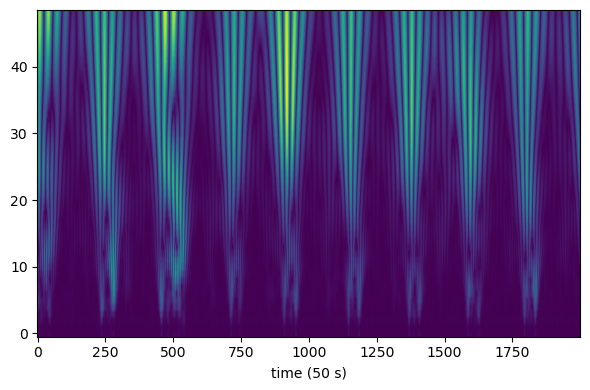

(49, 2000)


In [4]:
N = eeg.shape[0]
t0=0
dt=1.0/fs
time = np.arange(0, N) * dt + t0
signal = eeg.iloc[:,0]
scales = range(1,50)
waveletname = 'morl'
sampling_period = 1

coeff, freq = pywt.cwt(signal, scales, waveletname, sampling_period=sampling_period)

coeff = coeff[:,2000:4000]

x = (coeff - np.mean(coeff)) / np.std(coeff)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.imshow(abs(x), origin='lower', aspect='auto')
ax.set_xlabel('time (50 s)')

plt.tight_layout()
plt.show()
print(coeff.shape)



After pooling:

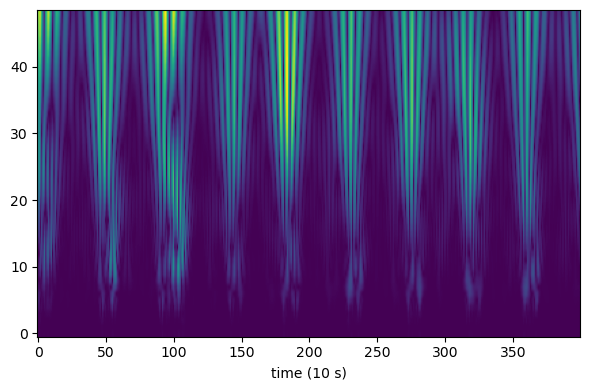

(49, 400)

In [7]:
pool_window = 5
coeff, freq = pywt.cwt(signal, scales, waveletname, sampling_period=sampling_period)
coeff = poolingOverlap(coeff,(1,pool_window),stride=None,method='mean',pad=False)
x = (coeff - np.mean(coeff)) / np.std(coeff)
start = int(2000/pool_window)
end = int(4000/pool_window)
x = x[:,start:end]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.imshow(abs(x), origin='lower', aspect='auto')
ax.set_xlabel('time (10 s)')

plt.tight_layout()
plt.show()

x.shape

## <a id='toc3_'></a>[Single file for cwt](#toc0_)

In [4]:
fmin = 1
fmax = 50
scales = np.arange(1,50)
waveletname = 'morl'
train_size = len(df_train)
# train_size = 100
val_size = len(df_val)
test_size= len(df_test)
n_channels = 5
dim1 = scales.shape[0]
pool_window = 5
dim2 = int(2000/pool_window)
sampling_period = 1
# Center 10 s adjusted by pooling window.
start2 = int(4000/pool_window)
end2 = int(6000/pool_window)

sgrams = np.empty((train_size, dim1, dim2, n_channels))
# item: [eeg_id, eeg_sub_id, idx in sgrams (1st index), target,
#       seizure_vote, lpd_vote, gpd_vote, lrda_vote,
#       grda_vote, other_vote]
items = np.array([], dtype=float).reshape(0,10)

for i in range(train_size):
    if i % 500 == 0:
        print(f'{i} eegs loaded', end='\r')
    item = df_train.iloc[i]
    eeg_full = pd.read_parquet(f'{base_dir}/train_eegs/{item.eeg_id}.parquet')
    # 50 second eeg sub sample
    offset = int(item.eeg_label_offset_seconds)
    start = offset * fs
    end = (offset + 50) * fs
    eeg_absolute = eeg_full[start:end]
    eeg_absolute = eeg_absolute.interpolate(limit_direction='both') # <<<<< Interpolation
    eeg = banana(eeg_absolute, filter=False)
    # X = np.empty((1, dim1, dim2, n_channels))
    # Averaging each chain in the banana montage.

    # Left temporal chain.
    coeff = np.zeros((dim1, 10000))
    # coeff = np.zeros((dim1, 6000))  # keeping 30 s to reduce runtime.
    for col in [0,1,2,3]:
        coeff_, freq = pywt.cwt(eeg.iloc[:,col], scales, waveletname, sampling_period=sampling_period)
        coeff = coeff + coeff_

    coeff = coeff/4
    coeff = poolingOverlap(coeff,(1,pool_window),stride=None,method='mean',pad=False)
    coeff = (coeff - np.mean(coeff)) / np.std(coeff)
    sgrams[i,:,:,0] = coeff[:,start2:end2].copy()

    # Right temporal chain.
    coeff = np.zeros((dim1, 10000))
    for col in [4,5,6,7]:
        coeff_, freq = pywt.cwt(eeg.iloc[:,col], scales, waveletname, sampling_period=sampling_period)
        coeff = coeff + coeff_

    coeff = coeff/4
    coeff = poolingOverlap(coeff,(1,pool_window),stride=None,method='mean',pad=False)
    coeff = (coeff - np.mean(coeff)) / np.std(coeff)
    sgrams[i,:,:,1] = coeff[:,start2:end2].copy()

    # Left parasagittal chain.
    coeff = np.zeros((dim1, 10000))
    for col in [8,9,10,11]:
        coeff_, freq = pywt.cwt(eeg.iloc[:,col], scales, waveletname, sampling_period=sampling_period)
        coeff = coeff + coeff_

    coeff = coeff/4
    coeff = poolingOverlap(coeff,(1,pool_window),stride=None,method='mean',pad=False)
    coeff = (coeff - np.mean(coeff)) / np.std(coeff)
    sgrams[i,:,:,2] = coeff[:,start2:end2].copy()

    # Right parasagittal chain.
    coeff = np.zeros((dim1, 10000))
    for col in [12,13,14,15]:
        coeff_, freq = pywt.cwt(eeg.iloc[:,col], scales, waveletname, sampling_period=sampling_period)
        coeff = coeff + coeff_

    coeff = coeff/4
    coeff = poolingOverlap(coeff,(1,pool_window),stride=None,method='mean',pad=False)
    coeff = (coeff - np.mean(coeff)) / np.std(coeff)
    sgrams[i,:,:,3] = coeff[:,start2:end2].copy()

    # Central chain.
    coeff = np.zeros((dim1, 10000))
    for col in [16,17]:
        coeff_, freq = pywt.cwt(eeg.iloc[:,col], scales, waveletname, sampling_period=sampling_period)
        coeff = coeff + coeff_

    coeff = coeff/2
    coeff = poolingOverlap(coeff,(1,pool_window),stride=None,method='mean',pad=False)
    coeff = (coeff - np.mean(coeff)) / np.std(coeff)
    sgrams[i,:,:,4] = coeff[:,start2:end2].copy()

    xitem = np.array([item.eeg_id, item.eeg_sub_id, i, item.target,
                    item.seizure_vote, item.lpd_vote, item.gpd_vote,
                    item.lrda_vote, item.grda_vote, item.other_vote],
                    dtype=float).reshape(1,10)
    items = np.concatenate([items, xitem])

filename = '05_single_cwt_v1_train'     
print(f'Saving to {filename}.npy')
print(f'Saving to {filename}_items.npy')
np.save(f'{output_dir}{filename}.npy', sgrams)
np.save(f'{output_dir}{filename}_items.npy', items)



Saving to 05_single_cwt_v1_train.npy
Saving to 05_single_cwt_v1_train_items.npy


In [8]:
# Validation set

sgrams = np.empty((val_size, dim1, dim2, n_channels))
# item: [eeg_id, eeg_sub_id, idx in sgrams (1st index), target,
#       seizure_vote, lpd_vote, gpd_vote, lrda_vote,
#       grda_vote, other_vote]
items = np.array([], dtype=float).reshape(0,10)

for i in range(val_size):
    if i % 500 == 0:
        print(f'{i} eegs loaded', end='\r')
    item = df_val.iloc[i]
    eeg_full = pd.read_parquet(f'{base_dir}/train_eegs/{item.eeg_id}.parquet')
    # 50 second eeg sub sample
    offset = int(item.eeg_label_offset_seconds)
    start = offset * fs
    end = (offset + 50) * fs
    eeg_absolute = eeg_full[start:end]
    eeg_absolute = eeg_absolute.interpolate(limit_direction='both') # <<<<< Interpolation
    eeg = banana(eeg_absolute, filter=False)
    # X = np.empty((1, dim1, dim2, n_channels))
    # Averaging each chain in the banana montage.

    # Left temporal chain.
    coeff = np.zeros((dim1, 10000))
    # coeff = np.zeros((dim1, 6000))  # keeping 30 s to reduce runtime.
    for col in [0,1,2,3]:
        coeff_, freq = pywt.cwt(eeg.iloc[:,col], scales, waveletname, sampling_period=sampling_period)
        coeff = coeff + coeff_

    coeff = coeff/4
    coeff = poolingOverlap(coeff,(1,pool_window),stride=None,method='mean',pad=False)
    coeff = (coeff - np.mean(coeff)) / np.std(coeff)
    sgrams[i,:,:,0] = coeff[:,start2:end2].copy()

    # Right temporal chain.
    coeff = np.zeros((dim1, 10000))
    for col in [4,5,6,7]:
        coeff_, freq = pywt.cwt(eeg.iloc[:,col], scales, waveletname, sampling_period=sampling_period)
        coeff = coeff + coeff_

    coeff = coeff/4
    coeff = poolingOverlap(coeff,(1,pool_window),stride=None,method='mean',pad=False)
    coeff = (coeff - np.mean(coeff)) / np.std(coeff)
    sgrams[i,:,:,1] = coeff[:,start2:end2].copy()

    # Left parasagittal chain.
    coeff = np.zeros((dim1, 10000))
    for col in [8,9,10,11]:
        coeff_, freq = pywt.cwt(eeg.iloc[:,col], scales, waveletname, sampling_period=sampling_period)
        coeff = coeff + coeff_

    coeff = coeff/4
    coeff = poolingOverlap(coeff,(1,pool_window),stride=None,method='mean',pad=False)
    coeff = (coeff - np.mean(coeff)) / np.std(coeff)
    sgrams[i,:,:,2] = coeff[:,start2:end2].copy()

    # Right parasagittal chain.
    coeff = np.zeros((dim1, 10000))
    for col in [12,13,14,15]:
        coeff_, freq = pywt.cwt(eeg.iloc[:,col], scales, waveletname, sampling_period=sampling_period)
        coeff = coeff + coeff_

    coeff = coeff/4
    coeff = poolingOverlap(coeff,(1,pool_window),stride=None,method='mean',pad=False)
    coeff = (coeff - np.mean(coeff)) / np.std(coeff)
    sgrams[i,:,:,3] = coeff[:,start2:end2].copy()

    # Central chain.
    coeff = np.zeros((dim1, 10000))
    for col in [16,17]:
        coeff_, freq = pywt.cwt(eeg.iloc[:,col], scales, waveletname, sampling_period=sampling_period)
        coeff = coeff + coeff_

    coeff = coeff/2
    coeff = poolingOverlap(coeff,(1,pool_window),stride=None,method='mean',pad=False)
    coeff = (coeff - np.mean(coeff)) / np.std(coeff)
    sgrams[i,:,:,4] = coeff[:,start2:end2].copy()

    xitem = np.array([item.eeg_id, item.eeg_sub_id, i, item.target,
                    item.seizure_vote, item.lpd_vote, item.gpd_vote,
                    item.lrda_vote, item.grda_vote, item.other_vote],
                    dtype=float).reshape(1,10)
    items = np.concatenate([items, xitem])

filename = '05_single_cwt_v1_val'     
print(f'Saving to {filename}.npy')
print(f'Saving to {filename}_items.npy')
np.save(f'{output_dir}{filename}.npy', sgrams)
np.save(f'{output_dir}{filename}_items.npy', items)



Saving to 05_single_cwt_v1_val.npy
Saving to 05_single_cwt_v1_val_items.npy


In [9]:
# Testing set

sgrams = np.empty((test_size, dim1, dim2, n_channels))
# item: [eeg_id, eeg_sub_id, idx in sgrams (1st index), target,
#       seizure_vote, lpd_vote, gpd_vote, lrda_vote,
#       grda_vote, other_vote]
items = np.array([], dtype=float).reshape(0,10)

for i in range(test_size):
    if i % 500 == 0:
        print(f'{i} eegs loaded', end='\r')
    item = df_test.iloc[i]
    eeg_full = pd.read_parquet(f'{base_dir}/train_eegs/{item.eeg_id}.parquet')
    # 50 second eeg sub sample
    offset = int(item.eeg_label_offset_seconds)
    start = offset * fs
    end = (offset + 50) * fs
    eeg_absolute = eeg_full[start:end]
    eeg_absolute = eeg_absolute.interpolate(limit_direction='both') # <<<<< Interpolation
    eeg = banana(eeg_absolute, filter=False)
    # X = np.empty((1, dim1, dim2, n_channels))
    # Averaging each chain in the banana montage.

    # Left temporal chain.
    coeff = np.zeros((dim1, 10000))
    # coeff = np.zeros((dim1, 6000))  # keeping 30 s to reduce runtime.
    for col in [0,1,2,3]:
        coeff_, freq = pywt.cwt(eeg.iloc[:,col], scales, waveletname, sampling_period=sampling_period)
        coeff = coeff + coeff_

    coeff = coeff/4
    coeff = poolingOverlap(coeff,(1,pool_window),stride=None,method='mean',pad=False)
    coeff = (coeff - np.mean(coeff)) / np.std(coeff)
    sgrams[i,:,:,0] = coeff[:,start2:end2].copy()

    # Right temporal chain.
    coeff = np.zeros((dim1, 10000))
    for col in [4,5,6,7]:
        coeff_, freq = pywt.cwt(eeg.iloc[:,col], scales, waveletname, sampling_period=sampling_period)
        coeff = coeff + coeff_

    coeff = coeff/4
    coeff = poolingOverlap(coeff,(1,pool_window),stride=None,method='mean',pad=False)
    coeff = (coeff - np.mean(coeff)) / np.std(coeff)
    sgrams[i,:,:,1] = coeff[:,start2:end2].copy()

    # Left parasagittal chain.
    coeff = np.zeros((dim1, 10000))
    for col in [8,9,10,11]:
        coeff_, freq = pywt.cwt(eeg.iloc[:,col], scales, waveletname, sampling_period=sampling_period)
        coeff = coeff + coeff_

    coeff = coeff/4
    coeff = poolingOverlap(coeff,(1,pool_window),stride=None,method='mean',pad=False)
    coeff = (coeff - np.mean(coeff)) / np.std(coeff)
    sgrams[i,:,:,2] = coeff[:,start2:end2].copy()

    # Right parasagittal chain.
    coeff = np.zeros((dim1, 10000))
    for col in [12,13,14,15]:
        coeff_, freq = pywt.cwt(eeg.iloc[:,col], scales, waveletname, sampling_period=sampling_period)
        coeff = coeff + coeff_

    coeff = coeff/4
    coeff = poolingOverlap(coeff,(1,pool_window),stride=None,method='mean',pad=False)
    coeff = (coeff - np.mean(coeff)) / np.std(coeff)
    sgrams[i,:,:,3] = coeff[:,start2:end2].copy()

    # Central chain.
    coeff = np.zeros((dim1, 10000))
    for col in [16,17]:
        coeff_, freq = pywt.cwt(eeg.iloc[:,col], scales, waveletname, sampling_period=sampling_period)
        coeff = coeff + coeff_

    coeff = coeff/2
    coeff = poolingOverlap(coeff,(1,pool_window),stride=None,method='mean',pad=False)
    coeff = (coeff - np.mean(coeff)) / np.std(coeff)
    sgrams[i,:,:,4] = coeff[:,start2:end2].copy()

    xitem = np.array([item.eeg_id, item.eeg_sub_id, i, item.target,
                    item.seizure_vote, item.lpd_vote, item.gpd_vote,
                    item.lrda_vote, item.grda_vote, item.other_vote],
                    dtype=float).reshape(1,10)
    items = np.concatenate([items, xitem])

filename = '05_single_cwt_v1_test'     
print(f'Saving to {filename}.npy')
print(f'Saving to {filename}_items.npy')
np.save(f'{output_dir}{filename}.npy', sgrams)
np.save(f'{output_dir}{filename}_items.npy', items)



Saving to 05_single_cwt_v1_test.npy
Saving to 05_single_cwt_v1_test_items.npy


Testing output.

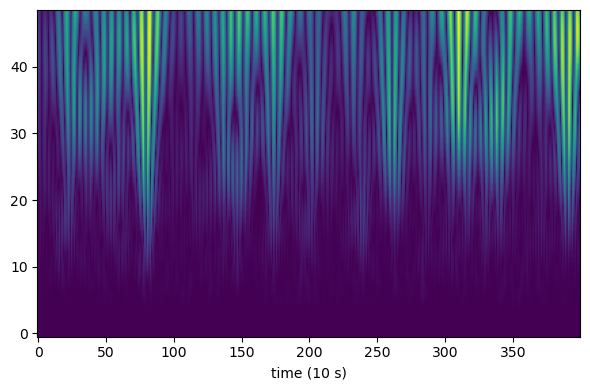

In [18]:

x = sgrams[351,:,:,4]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.imshow(abs(x), origin='lower', aspect='auto')
ax.set_xlabel('time (10 s)')

plt.tight_layout()
plt.show()

